<a href="https://colab.research.google.com/github/yeolcook01/NLP/blob/main/nsmc_data_binary_classification_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://colab.research.google.com/drive/14axheU9-Ij5s7KV5Q_8LloMModRNhTLw?usp=sharing

# 0.준비

시작하기 전에, 모든 환경에서 동일한 결과를 재현할 수 있도록 seed 값을 고정시킨다.

In [ ]:
import random
import numpy as np
import torch

seed = 1067 # https://www.youtube.com/watch?v=BsiqjGgwuU8&t=7s

def set_seed(seed=seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  PYTHONHASHSEED = seed

set_seed(seed)

In [ ]:
# 파이토치 라이브러리
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim #최적화기
from torch.utils.data import Dataset, DataLoader, random_split #데이터셋

In [ ]:
!pip -q install datasets #q옵션 넣어서 박스가 너무 커지지 않게 조절

     |████████████████████████████████| 342 kB 10.0 MB/s 
     |████████████████████████████████| 212 kB 64.9 MB/s 
     |████████████████████████████████| 84 kB 3.9 MB/s 
     |████████████████████████████████| 1.1 MB 58.9 MB/s 
     |████████████████████████████████| 136 kB 65.8 MB/s 
     |████████████████████████████████| 127 kB 71.2 MB/s 
     |████████████████████████████████| 144 kB 67.2 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████████████████████████████| 271 kB 50.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


NSMC 데이터셋을 처리할 수 있도록 datasets 라이브러리를 설치한다.

In [ ]:
from datasets import load_dataset #datasets는 허깅페이스에서 등록한 것 #개인이 데이터 추가할 수 있음
dataset = load_dataset("nsmc")

Using custom data configuration default


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/150000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset nsmc downloaded and prepared to /root/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

데이터 탐색
- 훈련 집합의 텍스트들이 어떤 부류로 이루어져 있는지 살펴보자.
- 새로운 데이터 사용할 경우 이러한 레이블 확인이 필요하다.

In [ ]:
labels = set(dataset['train']['label'])
K = len(labels)
print(labels)
print(K)
# {0, 1}
# 2

{0, 1}
2


- 훈련 집합(train)과 시험 집합(test)으로 분할되어 있다.
- DatasetDict은 딕셔너리의 특수한 경우이다.

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


### **한글 텍스트 처리**
- 한글 언어 처리는 '띄어쓰기' 및 '조사'로 인해 전처리가 까다로운 편이다.
- 한글은 상대적으로 라틴어 계열의 언어보다 NLP 처리가 어려운 문제가 있다.
- **KoNLP**는 대표적인 파이썬 한글 형태소 패키지이며, 그 가운데 **Twitter** 형태소 분석 모듈은 한글 SNS 분석에 적합한 것이다.
- Twitter 객체의 morphs() 메서드를 이용하면, 입력으로 들어온 문장을 형태소 단어 형태로 tokenize하여 list 객체로 반환해줄 수 있다.
- 문장을 형태소 단어 형태로 반환하는 tokenizer 함수를 `tw_tokenizer()`로 생성하고, 해당 함수를 활용하여 한글 텍스트를 처리해줄 것이다.

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 6.0 MB/s 
     |████████████████████████████████| 448 kB 62.6 MB/s 


In [ ]:
from konlpy.tag import Twitter
from tqdm import tqdm

twitter = Twitter()
def tw_tokenizer(text):
    # 입력으로 들어온 text를 형태소 단어로 토큰화 하여 list 반환
    tokens_ko = twitter.morphs(text)
    return tokens_ko

# 훈련 집합의 텍스트에서 단어 임베딩 모형을 훈련시킬 수 있도록, 단어의 리스트로 분리하여 sentences라는 이름의 리스트로 저장
sentences = [tw_tokenizer(sentence) for sentence in tqdm(dataset['train']['document'])] 

/usr/local/lib/python3.7/dist-packages/konlpy/tag/_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')
100%|██████████| 150000/150000 [09:13<00:00, 270.95it/s]


### 단어 임베딩
- **FastText**는 Word2Vec 모형을 기본으로 하되 문자  n 그램을 반영하여 형태상의 유사성을 반영할 수 있도록 한 모형
- FastText가 한국어에 유리한 이유: 한국어는 형태론적으로 복잡한 교착어(하나의 어절에 여러 형태소가 붙어 있는 형태)에 해당한다. 이에 따라 영어와 달리 '학교에' '학교에서' 등등이 다른 단어인 것처럼 처리될 수 있다. 그러나, FastText는 둘이 비슷한 어감을 가짐을 포착할 수 있다.

초매개변수 조절
- `min_count=3` (코퍼스의 사이즈를 고려하여 3으로 수정하였다. min_count가 커질수록 vocabularly의 size는 작아진다.)
- `size=128` (벡터 차원의 default는 100이지만, 128에서 더 좋은 성능이 관측되었다.)
- skip-gram은 그대로 사용하였다.

In [ ]:
from gensim.models import FastText
ft = FastText(
    sentences=sentences, # corpus
    sg=1,
    min_count=3,
    seed=seed, workers=1, # seed를 고정시키고 workers=1로 잡아주면 재현 가능한 모형을 만들어줄 수 있음
    size=128
)

In [ ]:
V = len(ft.wv.vocab)
print(V)

33776


In [ ]:
d = ft.wv.vector_size
print(d)

128


# 1.신경망 구성

- 출력층 크기(감정부류 K)는 마음대로 바꾸면 안 된다.
- 초매개변수인 `hidden_size는 128`로 지정하였다.
- 은닉층은 한 개로만 쌓았다: 초매개변수 조절 과정에서 은닉층을 여러 개 쌓아본 결과, 오히려 과적합이 발생하였다. 본 태스크에서는 한 개의 은닉층으로도 충분히 높은 성능을 관측할 수 있었다.

In [ ]:
hidden_size = 128

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(LSTM, self).__init__()
    set_seed() # 초기화 시 랜덤값을 사용하므로 seed 통해 랜덤 통제
    
    # input -> hidden (LSTM)
    self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
    # hidden -> output (fully connected)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    # input -> hidden (for sentence classification, we use h_n only)
    _, (h, _) = self.lstm(x) #어차피 우리가 사용할 것은 마지막 은닉상태뿐. (나머지 자리에 있는 것은 밑줄로만 표시)

    # hidden -> output
    z = self.fc(h) # 소프트맥스 직전까지의 예측값 z
    return z

In [ ]:
net = LSTM(input_dim=d, hidden_dim=hidden_size, output_dim=K)
print(net)

LSTM(
  (lstm): LSTM(128, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


방금 만든 신경망을 GPU에서 사용할 수 있도록 설정하자.

In [ ]:
device = 'cuda:0'
net = net.to(device)

신경망에서 초기화된 가중치 매개변수들을 살펴보자.

In [ ]:
for (name, param) in net.named_parameters():
  print(f'{name}: {param.shape}')

lstm.weight_ih_l0: torch.Size([512, 128])
lstm.weight_hh_l0: torch.Size([512, 128])
lstm.bias_ih_l0: torch.Size([512])
lstm.bias_hh_l0: torch.Size([512])
fc.weight: torch.Size([2, 128])
fc.bias: torch.Size([2])


# 2. 데이터셋 구성

길이의 평균값: 14.37442
길이의 최댓값: 95


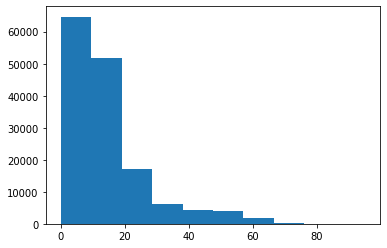

In [ ]:
lengths = [len(sentence) for sentence in sentences]
print(f'길이의 평균값: {np.mean(lengths)}')
print(f'길이의 최댓값: {np.max(lengths)}') #제일 긴 것은 127. 실제 평균은 9이므로 대부분이 길지 않음

import matplotlib.pyplot as plt

plt.hist(lengths)
plt.show()
#127인 것은 극히 일부분. 대부분이 40단어 미만

초매개변수 조절
- `max_len` : 훈련 데이터를 구성할 때 최대 길이를 정하고 해당 범위 내의 입력만을 사용하였다.
- `max_len = 24` : 주어진 텍스트를 충분히 활용하는 동시에 계산량이 지나치게 많아지지 않아야 하며, 이를 위해 훈련 집합을 이루는 각 영화평의 길이의 분포를 살펴봄으로써 적절한 최대 길이를 설정해야 한다. 위 코드를 통해 영화평의 길이 분포를 살펴본 결과 24의 max_length가 적절할 것으로 판단하였다.

In [ ]:
max_len = 24

벡터 표상

In [ ]:
def get_vec_seq(text, pad=True, max_len=max_len, device=device):
  words = tw_tokenizer(text) #text를 단어로 분리하여 words에 저장
  
  if pad:
    output = np.zeros((max_len, d)) #행렬이구나~
  else:
    output = np.zeros((len(words), d))
  for (i, word) in enumerate(words[:max_len]):
    try:
      output[i] = ft.wv[word] 
    except KeyError: 
      pass

  return torch.tensor(output, dtype=torch.float).to(device)

데이터셋 분할

In [ ]:
class NSMCDataset(Dataset):
  def __init__(self, split='train'): #초기화함수는 dataset을 상속해서 train인지 test인지 구분
    super(NSMCDataset, self).__init__()
    self.dataset = dataset[split]

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx): #index를 받아서 그 index에 해당하는 데이터(item)를 하나 반환
    # get idx-th data
    data = self.dataset[idx]
    # format: (word vector sequence of document, label)
    text = data['document']  
    label = data['label']
    input = get_vec_seq(text) 
    label = torch.tensor(label).to(device)
    # if text is empty
    if torch.isnan(input).sum():
      input = torch.zeros(max_len, ft.wv.vector_size).to(device)
    sample = (input, label)
    return sample

In [ ]:
train_dataset = NSMCDataset('train')
test_dataset = NSMCDataset('test') #훈련과정에서의 성능을 파악하기 위한 test dataset

In [ ]:
train_size = int(len(train_dataset)*0.9) #90%를 떼어둠
valid_size = len(train_dataset) - train_size #10%를 떼어둠

set_seed() #random_split 함수 사용하기 위해 seed 재설정.
train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size]) 

배치 처리
-  데이터를 하나씩 넣으면 계산이 느리므로, 여러 데이터를 하나의 배치(batch)로 묶어서 사용한다.
- data_loader 사용한다.
- `batch_size는 512`로 지정하였다.

In [ ]:
batch_size = 512
set_seed()
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

#3. 신경망 훈련

손실함수 저장
- 교차엔트로피 손실함수

In [ ]:
criterion = nn.CrossEntropyLoss()

최적화기 저장 (초매개변수)
- `Adam` optimizer
- `초기 학습률: 0.01` (본 데이터의 태스크에서는 learning_rate을 0.001로 두는 것보다 0.01일 때 높은 성능이 관측되었다.)

In [ ]:
learning_rate = 0.01
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) 

**훈련**
초매개변수 조절
- epochs 횟수는 지나치게 높을 경우 과적합이 발생하였다. 이에 따라 `num_epochs = 3 `으로 지정하였다.


In [ ]:
def get_accuracy(data_loader, net=net): # 지난 번과 달리 아예 함수로 만듦
  correct = 0 #data_loader에서, 맞게 맞춘 것을 correct로 저장

  for (inputs, labels) in tqdm(data_loader): 
    predicts = net(inputs).argmax(dim=-1).view(-1)
    correct += sum(predicts==labels)

  acc = correct / len(data_loader.dataset)

  return acc

In [ ]:
num_epochs = 3
step = 0
for epoch in range(num_epochs): #훈련집합을 몇 번 읽을 것인가
  for (inputs, labels) in train_loader:
    inputs = inputs.requires_grad_() #현재의 입력에서 편도함수를 저장할 수 있도록 requires_grad_()

    # Clear gradients w.r.t. parameters
    optimizer.zero_grad()

    # Forward pass to get output/logits
    outputs = net(inputs)
    outputs = outputs.view(outputs.shape[1:])

    # Calculate Loss: softmax --> cross entropy loss
    loss = criterion(outputs, labels)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # parameter 업데이트
    optimizer.step()

    if step % 50 == 0:
      print(f'Step: {step}, Training Loss: {loss.item()}.')
      #step이 50으로 나누어 떨어질 때마다 업데이트 현황 공유
    
    step += 1 #다음 단계로 넘어감

  acc = get_accuracy(valid_loader)

  # Print Loss and Accuracy
  print(f'Epoch: {epoch}. Training Loss: {loss.item()}. Validation Accuracy: {acc}')

Step: 0, Training Loss: 0.6967405080795288.
Step: 50, Training Loss: 0.5292371511459351.
Step: 100, Training Loss: 0.4048345685005188.
Step: 150, Training Loss: 0.38985446095466614.
Step: 200, Training Loss: 0.3541227877140045.
Step: 250, Training Loss: 0.3252609968185425.


100%|██████████| 30/30 [01:06<00:00,  2.21s/it]


Epoch: 0. Training Loss: 0.3300902247428894. Validation Accuracy: 0.8473333716392517
Step: 300, Training Loss: 0.3302558660507202.
Step: 350, Training Loss: 0.3441348671913147.
Step: 400, Training Loss: 0.3300267159938812.
Step: 450, Training Loss: 0.3380391597747803.
Step: 500, Training Loss: 0.37678319215774536.


100%|██████████| 30/30 [00:59<00:00,  1.99s/it]


Epoch: 1. Training Loss: 0.33764123916625977. Validation Accuracy: 0.8579999804496765
Step: 550, Training Loss: 0.34159642457962036.
Step: 600, Training Loss: 0.31144529581069946.
Step: 650, Training Loss: 0.3360723555088043.
Step: 700, Training Loss: 0.3500507175922394.
Step: 750, Training Loss: 0.3245960474014282.


100%|██████████| 30/30 [00:59<00:00,  1.99s/it]

Epoch: 2. Training Loss: 0.3356146216392517. Validation Accuracy: 0.8655333518981934


**평가**

In [ ]:
acc = get_accuracy(test_loader)
print(acc)

100%|██████████| 98/98 [03:27<00:00,  2.11s/it]

tensor(0.8533, device='cuda:0')
